## MO444 Project 3 - Reinforcement Learning

* Rodrigo Araújo Marinho Franco - RA: 233569
* Felipe Marinho Tavares - RA: 265680

### Contributions:
* Rodrigo
 * ...
* Felipe
 * ...

# PART I - Evolutionary Model

# PART II - Reinforcement Learning

In [1]:
import sys
sys.path.append("search/")

import torch
import matplotlib.pyplot as plt

import environment

## Medium Environment - Training

Initial state:


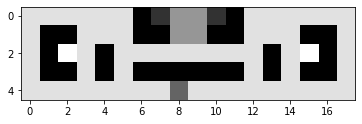

Shape:  (5, 18, 1)
Episode:  100 Average Score: -38.00 Winrate: 0.00%
Episode:  200 Average Score: -27.19 Winrate: 0.00%
Episode:  300 Average Score: -11.42 Winrate: 0.00%
Episode:  400 Average Score: -11.22 Winrate: 0.00%
Episode:  500 Average Score: -2.49 Winrate: 0.00%
Episode:  600 Average Score: 15.61 Winrate: 0.00%
Episode:  700 Average Score: 20.56 Winrate: 0.00%
Episode:  800 Average Score: 27.96 Winrate: 0.00%
Episode:  900 Average Score: 47.53 Winrate: 1.00%
Episode:  1000 Average Score: 51.78 Winrate: 0.00%
Episode:  1100 Average Score: 60.51 Winrate: 1.00%
Episode:  1200 Average Score: 82.42 Winrate: 3.00%
Episode:  1300 Average Score: 100.44 Winrate: 4.00%
Episode:  1400 Average Score: 90.35 Winrate: 4.00%
Episode:  1500 Average Score: 114.97 Winrate: 8.00%
Episode:  1600 Average Score: 135.53 Winrate: 6.00%
Episode:  1700 Average Score: 182.11 Winrate: 18.00%
Episode:  1800 Average Score: 176.93 Winrate: 17.00%
Episode:  1900 Average Score: 157.03 Winrate: 12.00%
Episode:

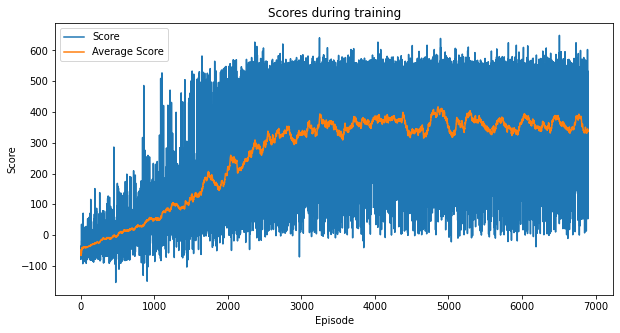

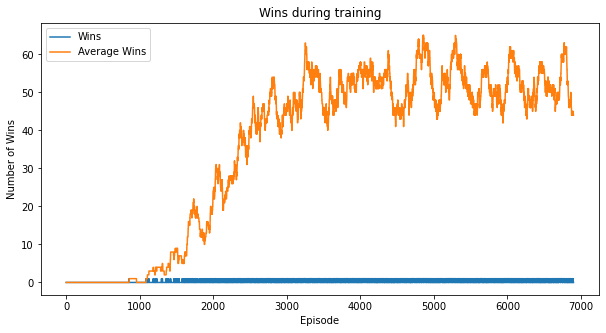

In [2]:
params = {
    "buffer_size": int(1e5),  # replay buffer size
    "batch_size": 32,        # minibatch size
    "gamma": 0.99,            # discount factor
    "tau": 1e-4,              # for soft update of target parameters
    "lr": 1e-4,               # learning rate
    "weight_decay": 0.0001,   # Adam parameter
    "update_every": 10         # how often to update the network
}

# layouts = smallClassic, mediumClassic, originalClassic
env = environment.Environment(params, layout="smallClassic", use_features=True)

eps_start = 1.0   # Starting exploration rate
eps_end = 0.05    # Minimun exploration rate (0.05 = 5%)
eps_decay=0.999
n_episodes = 10000
print_every = 100 # episodes
patience = 20      # max print_every without improvement tolarated
checkpoints_without_improvement = 0

eps = eps_start
best_score = -1000
for i_episode in range(1, n_episodes + 1):
    env.reset()

    while not env.done():
        env.step(eps)

    eps = max(eps_end, eps_decay*eps)

    env.scores.append(env.game.state.getScore())
    env.scores_window.append(env.game.state.getScore())

    env.wins.append(env.game.state.isWin())
    env.wins_window.append(env.game.state.isWin())

    average_score = sum(env.scores_window)/float(len(env.scores_window))
    winrate = sum(env.wins_window)/float(len(env.wins_window)) * 100.0
    env.average_scores.append(average_score)
    env.average_wins.append(winrate)

    if i_episode % print_every == 0:
        print("Episode: ", i_episode, end=" ")
        print('Average Score: {:.2f}'.format(average_score), end=" ")
        print('Winrate: {:.2f}%'.format(winrate))

        if average_score > best_score:
            checkpoints_without_improvement = 0
            best_score = average_score
            torch.save(env.pacman.qnetwork_local.state_dict(), 'models/checkpoint_small.pth')
        else:
            checkpoints_without_improvement += 1
            if checkpoints_without_improvement == patience:
                print("Stopping training due to lack of improvement")
                break

plt.figure(figsize=(10, 5))
plt.title("Scores during training")
plt.xlabel('Episode')
plt.ylabel('Score')
line1, = plt.plot(env.scores)
line2, = plt.plot(env.average_scores)
plt.legend([line1, line2], ["Score", "Average Score"])
plt.show()

plt.figure(figsize=(10, 5))
plt.title("Wins during training")
plt.xlabel('Episode')
plt.ylabel('Number of Wins')
line1, = plt.plot(env.average_wins)
plt.legend([line1], ["Average Wins"])
plt.show()